## 1. 텐서플로우 메모리 관리

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

2022-08-03 01:17:40.684515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 01:17:40.695285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 01:17:40.697099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 2. 패키지 로드

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Input, Conv2DTranspose
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
from PIL import Image
import cv2
from glob import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 3. 데이터 로드

In [3]:
# 데이터 로드
human_image_datas = glob('./image_human/*.jpg')
webtoon_image_datas = glob('./image_webtoon/*.jpg')

In [4]:
# 데이터 크기 확인
len(human_image_datas), len(webtoon_image_datas)

(10456, 27702)

## 4. 데이터 전처리

In [5]:
# 데이터 셋으로 합치기
data_set = [human_image_datas, webtoon_image_datas[:10456]]
X = []

for data in tqdm(data_set):
    for image_name in tqdm(data):
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        ret, thres = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        image = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)
        X.append(image)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

In [6]:
# Numpy 배열로 변경
X = np.array(X)

In [7]:
# train data 와 test data로 나누기
train_images, test_images = train_test_split(X, test_size=0.2, shuffle=True, random_state = 41)

In [8]:
# 이미지 픽셀의 값을 0~1 사이의 값으로 만들기
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

In [9]:
# shape 확인
train_images.shape, test_images.shape

((16729, 32, 32, 3), (4183, 32, 32, 3))

## 5. 모델 생성

In [13]:
# params 설정
learning_rate = 0.01
epochs = 1000
batch_size = 32
latent_dim = 64

In [14]:
class AutoEncoder(Model):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        # 인코더 정의
        self.encoder = tf.keras.Sequential([
            Input(shape=(32, 32, 3)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')
        ])
        
        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [15]:
autoEncoder = AutoEncoder(latent_dim)
autoEncoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./models_2D/autoencoder_Conv2D_cp.ckpt', verbos=1, save_best_only=True, save_weights_only=True, monitor='val_mse', mode='min')
earlystopping = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=20)

## 6. 모델 학습

In [16]:
history = autoEncoder.fit(train_images, train_images,
                epochs=epochs,
                shuffle=True,
                validation_data=(test_images, test_images), workers=2, callbacks=[checkpointer, earlystopping], batch_size=batch_size)

2022-08-03 01:21:35.478381: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205565952 exceeds 10% of free system memory.
2022-08-03 01:21:35.693134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205565952 exceeds 10% of free system memory.
2022-08-03 01:21:35.928808: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205565952 exceeds 10% of free system memory.
2022-08-03 01:21:36.075263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205565952 exceeds 10% of free system memory.


Epoch 1/1000


2022-08-03 01:21:38.601640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-08-03 01:21:40.793581: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


523/523 [==============================] - ETA: 0s - loss: 0.0570 - mse: 0.0570

2022-08-03 01:21:52.956336: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51400704 exceeds 10% of free system memory.


523/523 [==============================] - 18s 20ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 2/1000
523/523 [==============================] - 8s 16ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 3/1000
523/523 [==============================] - 8s 15ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 4/1000
523/523 [==============================] - 8s 16ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 5/1000
523/523 [==============================] - 9s 17ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 6/1000
523/523 [==============================] - 8s 16ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 7/1000
523/523 [==============================] - 8s 16ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/1000
523/523 [==============================] - 9s 16ms/ste

Epoch 60/1000
523/523 [==============================] - 8s 15ms/step - loss: 5.1883e-04 - mse: 5.1883e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 61/1000
523/523 [==============================] - 9s 17ms/step - loss: 5.1452e-04 - mse: 5.1452e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 62/1000
523/523 [==============================] - 8s 16ms/step - loss: 5.0109e-04 - mse: 5.0109e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 63/1000
523/523 [==============================] - 9s 16ms/step - loss: 4.7675e-04 - mse: 4.7675e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 64/1000
523/523 [==============================] - 8s 16ms/step - loss: 4.8208e-04 - mse: 4.8208e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 65/1000
523/523 [==============================] - 8s 16ms/step - loss: 4.6364e-04 - mse: 4.6364e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 66/1000
523/523 [==============================] - 8s 16ms/step - loss: 4.9433e-04 - mse: 4.9433e-04 - val_loss: 0.0012 - val_mse:

## 7. 평가 : 재구성 오류 (MSE)로 확인

In [17]:
import pandas as pd

131/131 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0011


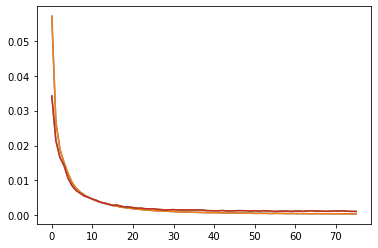

In [18]:
history_eval = autoEncoder.evaluate(test_images, test_images)
plt.plot(pd.DataFrame(history.history))
plt.show()

## 8. 예측 및 테스트

In [20]:
encoded_imgs = autoEncoder.encoder(test_images[:100]).numpy()
decoded_imgs = autoEncoder.decoder(encoded_imgs).numpy()

In [21]:
encoded_imgs.shape, decoded_imgs.shape

((100, 8, 8, 64), (100, 32, 32, 1))

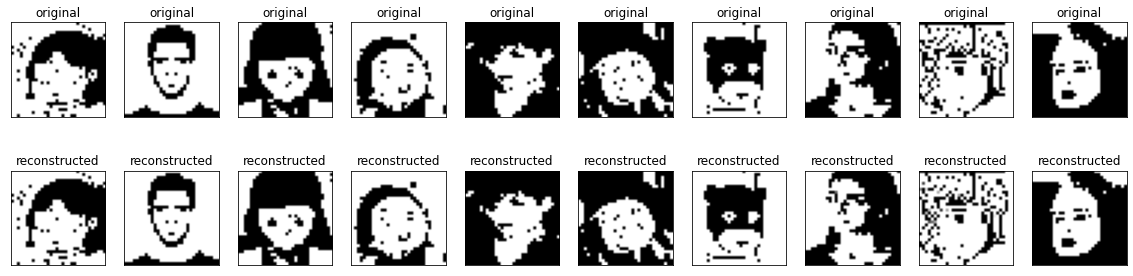

In [22]:
n = 10

plt.figure(figsize=(2 * 10, 5))

for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_images[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 모델 로드

In [28]:
load_model = AutoEncoder(64)

In [29]:
load_model.load_weights('./models_2D/autoencoder_Conv2D_cp.ckpt')

In [30]:
load_model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])

In [31]:
load_model.evaluate(test_images, test_images)

131/131 [==============================] - 1s 7ms/step - loss: 0.0011 - mse: 0.0011


[0.0011136133689433336, 0.0011136133689433336]